# GBE Simulation using MLMC

In [25]:
from pymlmc import mlmc_test, mlmc_plot
import matplotlib.pyplot as plt
import numpy
import numpy.random
from math import sqrt
from IPython.display import Image

In [26]:
class CallType(object):
    def __init__(self, name, M, N, L, Eps):
        self.name = name
        self.M = M # refinement cost factor
        self.N = N # samples for convergence tests
        self.L = L # levels for convergence tests
        self.Eps = Eps

calltypes = [CallType("European",  4, 200000, 5, [0.005, 0.01, 0.02, 0.05, 0.1])]

In [27]:
def opre_gbm(l, N, calltype, randn=numpy.random.randn):
    M = calltype.M # refinement factor

    T   = 1.0  # interval
    r   = 0.05
    sig = 0.2
    K   = 100.0

    nf = M**l
    hf = T/nf

    nc = max(nf/M, 1)
    hc = T/nc

    sums = numpy.zeros(6)

    for N1 in range(1, N+1, 10000):
        N2 = min(10000, N - N1 + 1)

        X0 = K
        Xf = X0 * numpy.ones(N2)
        Xc = X0 * numpy.ones(N2)

        if l == 0:
            dWf = sqrt(hf) * randn(1, N2)
            Xf[:] = Xf + r*Xf*hf + sig*Xf*dWf

        else:
            for n in range(int(nc)):
                dWc = numpy.zeros((1, N2))

                for m in range(M):
                    dWf = sqrt(hf) * randn(1, N2)
                    dWc[:] = dWc + dWf
                    Xf[:] = (1.0 + r*hf)*Xf + sig*Xf*dWf


                Xc[:] = Xc + r*Xc*hc + sig*Xc*dWc

        Pf = numpy.maximum(0, Xf - K)
        Pc = numpy.maximum(0, Xc - K)
            
        """   
        newPf = numpy.copy(Pf)
        f1 = plt.figure()
        f2 = plt.figure()
        f3 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Xf)
        ax1.set_title(str(N1)+" X level "+str(l))
        ax2 = f2.add_subplot(111)
        ax2.set_title(str(N1)+" P level "+str(l))
        ax2.plot(newPf)
        """
        Pf = numpy.exp(-r*T)*Pf
        Pc = numpy.exp(-r*T)*Pc

        """
        ax3 = f3.add_subplot(111)
        ax3.set_title(str(N1)+" New P level "+str(l))
        ax3.plot(Pf)
        plt.show()
        """

        sums += numpy.array([numpy.sum(Pf - Pc),
                             numpy.sum((Pf - Pc)**2),
                             numpy.sum((Pf - Pc)**3),
                             numpy.sum((Pf - Pc)**4),
                             numpy.sum(Pf),
                             numpy.sum(Pf**2)])

        cost = N*nf # cost defined as number of fine timesteps
        
    return (numpy.array(sums), cost)


 ---- European Call ---- 


**********************************************************
*** MLMC file version 0.9     produced by              ***
*** Python mlmc_test on 06-November-2022 19:12:46           ***
**********************************************************

**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
*** using N = 200000 samples                           ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)  var(Pf)   kurtosis    check     cost
-------------------------------------------------------------------------------
 0   1.0223e+01  1.0223e+01  1.618e+02  1.618e+02  0.00e+00  0.00e+00  1.00e+00 
 1   2.0358e-01  1.0392e+01  4.458e+00  2.005e+02  2.03e+01  1.78e-01  4.00e+00 
 2   3.2319e-02  1.0377e+01  1.054e+00  2.117e+02  1.20e+01  2.37e-01  1.60e+01 
 3   7.1699e-03  1.0435e+01  2.736e-01  2.155e+02  7.45e+00  2.54e-01  6.40e+01 
 4   1.925

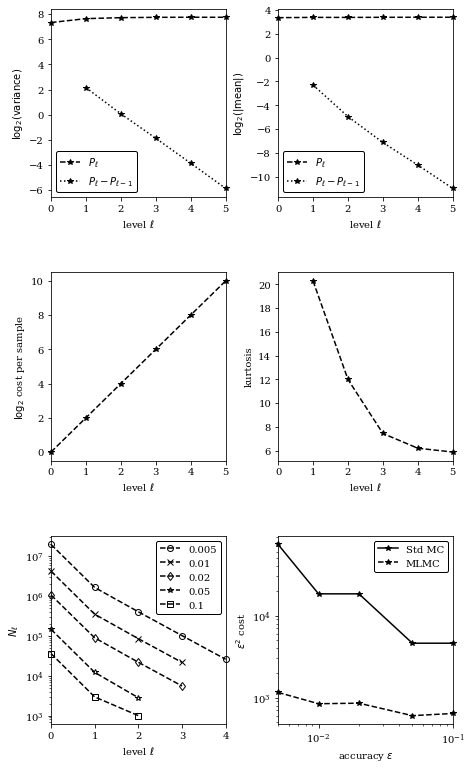

In [28]:
N0 = 1000 # initial samples on coarse levels
Lmin = 2  # minimum refinement level
Lmax = 6  # maximum refinement level
%matplotlib inline

for (i, calltype) in enumerate(calltypes):
    def opre_l(l, N):
        return opre_gbm(l, N, calltype)

    filename = "opre_gbm%d.txt" % (i+1)
    logfile = open(filename, "w")
    print('\n ---- ' + calltype.name + ' Call ---- \n')
    mlmc_test(opre_l, calltype.N, calltype.L, N0, calltype.Eps, Lmin, Lmax, logfile)
    del logfile
    mlmc_plot(filename, nvert=3)
    plt.savefig(filename.replace('.txt', '.png'))
    Image(filename='opre_gbm1.png') 
    